In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import MarketReturns, AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal
from cvx_portfolio.risks import EmpSigma
from cvx_portfolio.constraints import LeverageLimit  


plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

In [3]:
np.random.seed(1)
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')

/home/enzo/repos/cvx_portfolio/cvx_portfolio/data/generator.py:30: RuntimeWarning: overflow encountered in exp
  sig*ex*np.concatenate([[0],np.cumsum(np.sqrt(np.diff(np.exp(2*th*t)-1))*np.random.randn(len(t)-1))])
/home/enzo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:1768: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


## Market simulator 

In [4]:
del volumes['USDOLLAR']
del sigmas['USDOLLAR']

spread = pd.DataFrame(data=5e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns)

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')

simulator = MarketSimulator(MarketReturns(returns), volumes, [simulated_tcost], cash_key='USDOLLAR')

alpha_model = AlphaSource(0.0001 * alpha_signal)

risk_model = EmpSigma(returns, lookback=500)

## Portfolio

In [5]:
p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)
p_0 = 1E8*p

## Policy

In [6]:
# values smaller than .2 give bad returns. larger than .4 we almost don't trade.
gamma_tcosts = [.2, .3, .4]
gamma_tcosts

[0.2, 0.3, 0.4]

In [7]:
# values smaller than .3 give basically same result as with 0. 
gamma_risks = np.logspace(-.5,1,3)
gamma_risks = [0.] + list(gamma_risks)
gamma_risks

[0.0, 0.31622776601683794, 1.7782794100389228, 10.0]

In [8]:
policies={}
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts:
        policies[(gamma_risk, gamma_tcost)] = \
                SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost], [LeverageLimit(3)])

## Simulations

In [9]:
five_years=returns.index[(returns.index>"2012-01-01")] # "2012-01-01"
results = simulator.run_multiple_backtest(p_0, five_years, policies=policies.values())
results=dict(zip(policies.keys(), results))

In [55]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], k[1]] = results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

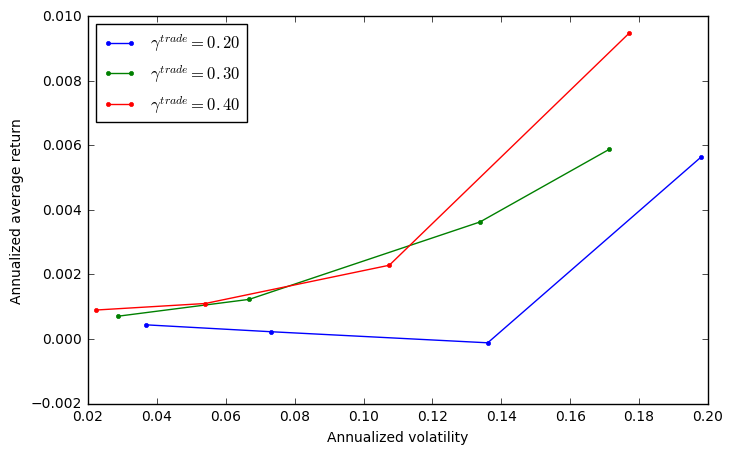

In [95]:
plt.figure(figsize=(8,5))
for gamma_tcost in gamma_tcosts:
    #plt.figure()
    x = [result_df.loc[(i, gamma_tcost)].volatility for i in gamma_risks]
    y = [result_df.loc[(i, gamma_tcost)].mean_return for i in gamma_risks]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^{trade} = %.2f$'%gamma_tcost)
plt.legend(loc='upper left')
plt.xlabel('Annualized volatility')
plt.ylabel('Annualized average return')
plt.savefig(plotdir+'spo_riskrewardfrontier.png')

In [56]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,0.2,0.3,0.4
gamma_risk,,,
0.000000,0.446071,0.537427,0.842453
0.316228,-0.022082,0.421495,0.326882
1.778279,0.033452,0.274731,0.301944
10.000000,0.159035,0.351259,0.588070


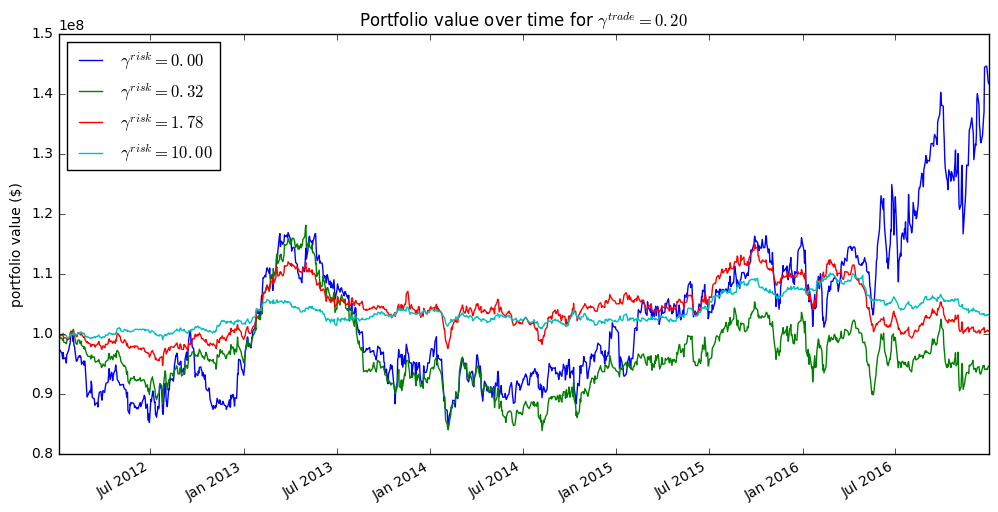

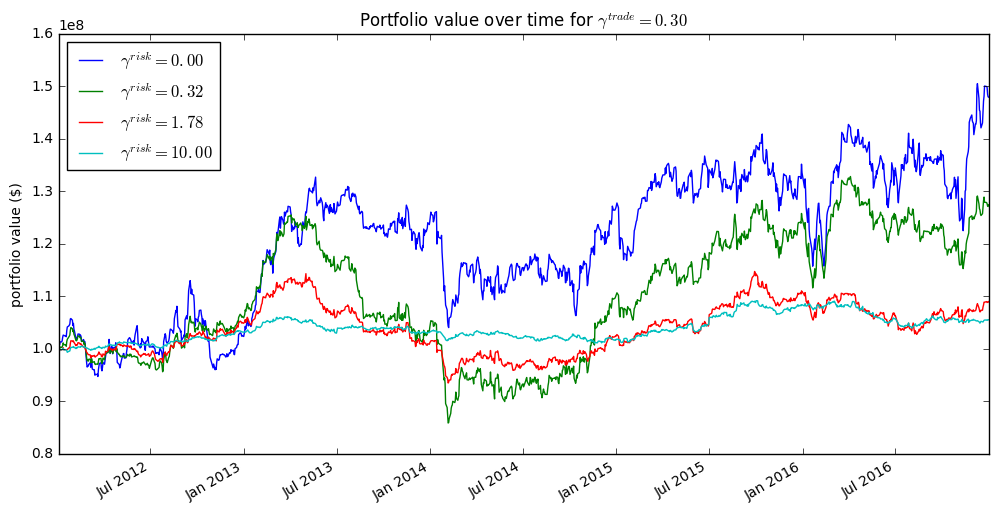

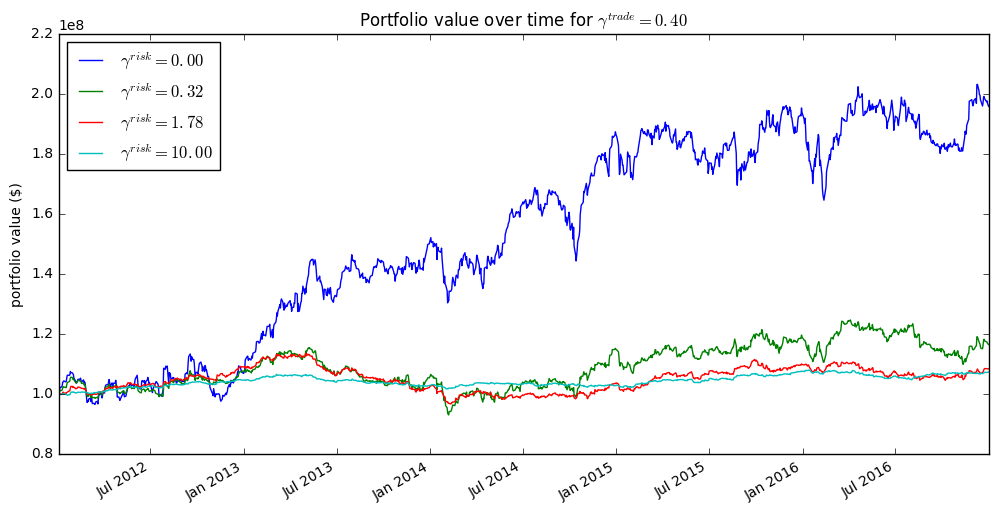

In [94]:
for i in range(3):
    gamma_tcost = gamma_tcosts[i]
    plt.figure(figsize=(12,6))
    [results[(i, gamma_tcost)].v.plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
    plt.legend(loc='upper left')
    plt.ylabel('portfolio value (\$)')
    plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
    plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

## Other diagnostics

([0.0, 0.31622776601683794, 1.7782794100389228, 10.0], 0.4)

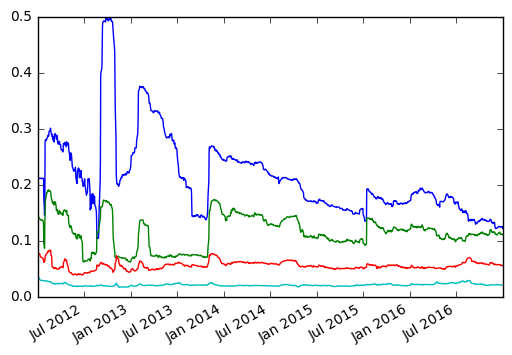

In [33]:
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcosts[2])].policy_EmpSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.31622776601683794, 1.7782794100389228, 10.0], 0.2)

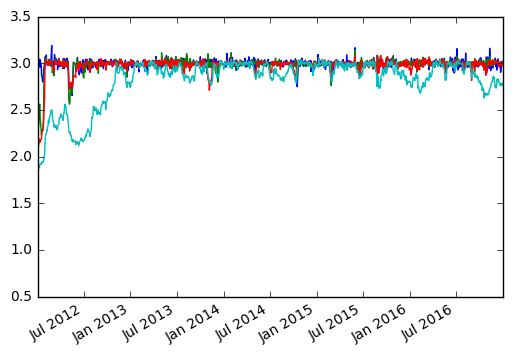

In [25]:
[results[(i, gamma_tcosts[0])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[0]

([0.0, 0.31622776601683794, 1.7782794100389228, 10.0], 0.3)

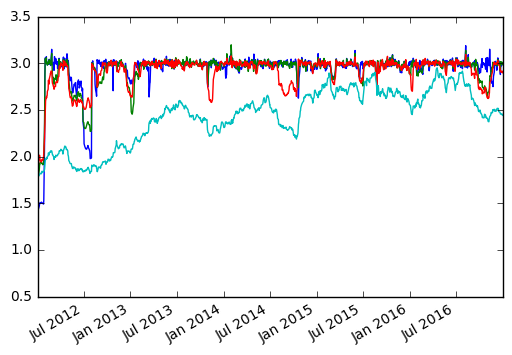

In [26]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

([0.0, 0.31622776601683794, 1.7782794100389228, 10.0], 0.4)

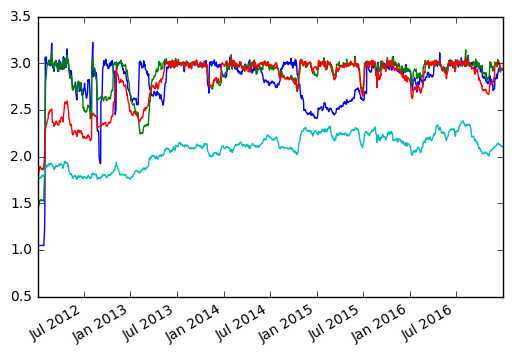

In [24]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.31622776601683794, 1.7782794100389228, 10.0], 0.4)

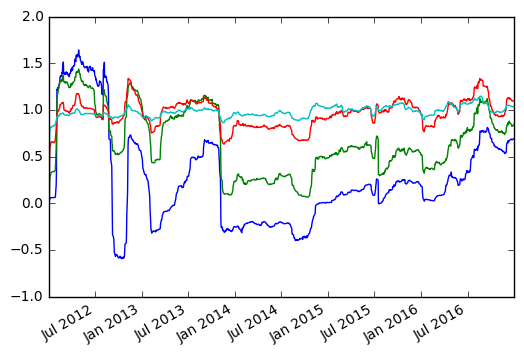

In [27]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.31622776601683794, 1.7782794100389228, 10.0], 0.4)

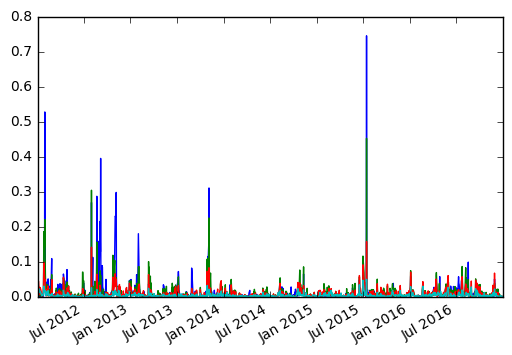

In [30]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

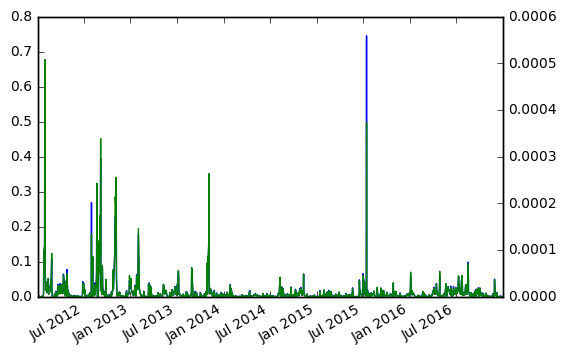

In [59]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

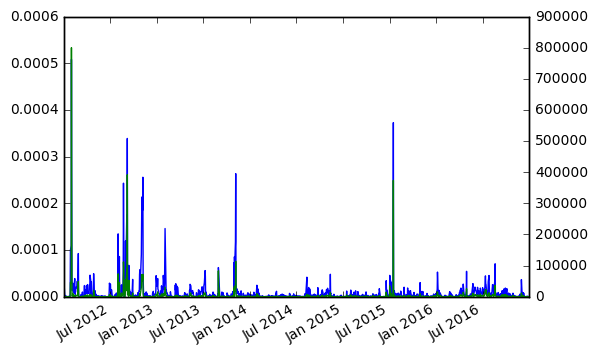

In [60]:
res.policy_TcostModel.sum(1).plot()
res.simulator_TcostModel.sum(1).plot(secondary_y=True)

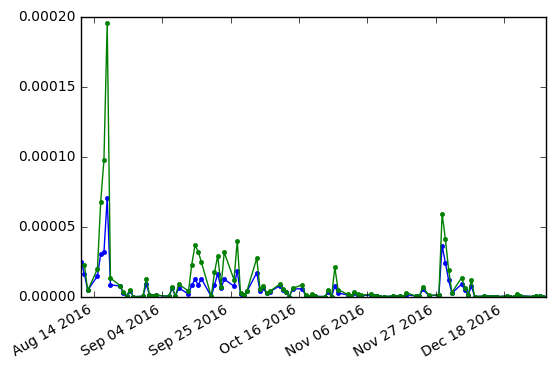

In [61]:
(res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
(res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')